In [13]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
sys.path.append("../data/biasbios")
sys.path.append("../data/embeddings/biasbios")
import classifier
import svm_classifier
import debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM

import scipy
from scipy import linalg
from scipy import sparse
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

import pickle
from collections import defaultdict, Counter
from typing import List, Dict

import torch
from torch import utils

import pytorch_lightning as pl
from pytorch_lightning import Trainer
import copy
import pandas as pd
from gensim.models import FastText
import time
from gensim.scripts.glove2word2vec import glove2word2vec

STOPWORDS = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def load_dataset(path):
    
    with open(path, "rb") as f:
        
        data = pickle.load(f)
    return data

def load_dictionary(path):
    
    with open(path, "r", encoding = "utf-8") as f:
        
        lines = f.readlines()
        
    k2v, v2k = {}, {}
    for line in lines:
        
        k,v = line.strip().split("\t")
        v = int(v)
        k2v[k] = v
        v2k[v] = k
    
    return k2v, v2k
    
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["g"], entry["p"]
        counter[prof][gender] += 1
        
    return counter

In [4]:
train = load_dataset("../data/biasbios/hila/train.pickle")
dev = load_dataset("../data/biasbios/hila/dev.pickle")
test = load_dataset("../data/biasbios/hila/test.pickle")
counter = count_profs_and_gender(train+dev+test)
p2i, i2p = load_dictionary("../data/biasbios/profession2index.txt")
g2i, i2g = load_dictionary("../data/biasbios/gender2index.txt")

path = "/home/nlp/lazary/workspace/thesis/nullspace_projection/data/bert_encode_biasbios_even_splits_hila/"
x_train = np.load(path + "train_cls.npy")
x_dev = np.load(path + "dev_cls.npy")
x_test = np.load(path + "test_cls.npy")

assert len(train) == len(x_train)
assert len(dev) == len(x_dev)
assert len(test) == len(x_test)

f,m = 0., 0.
prof2fem = dict()

for k, values in counter.items():
    f += values['f']
    m += values['m']
    prof2fem[k] = values['f']/(values['f'] + values['m'])

print(f / (f + m))
print(prof2fem)

0.46286566875856267
{'teacher': 0.603111879476414, 'professor': 0.45118956904580476, 'attorney': 0.38316925813475633, 'surgeon': 0.14857228961048746, 'photographer': 0.35721920736720936, 'painter': 0.4579886246122027, 'psychologist': 0.6223011751844766, 'filmmaker': 0.3295762590954487, 'physician': 0.507688318423441, 'interior_designer': 0.8086124401913876, 'architect': 0.23712053792148718, 'dietitian': 0.9273504273504274, 'pastor': 0.24052132701421802, 'rapper': 0.09665955934612651, 'journalist': 0.49488721804511276, 'dentist': 0.35589474411216243, 'accountant': 0.36818825194621374, 'poet': 0.49080017115960634, 'model': 0.8283124500133298, 'nurse': 0.9085446207369142, 'chiropractor': 0.26558891454965355, 'yoga_teacher': 0.8454600120264583, 'software_engineer': 0.1576889661164205, 'paralegal': 0.8483305036785512, 'composer': 0.16392857142857142, 'personal_trainer': 0.45670391061452514, 'comedian': 0.21150410861021793, 'dj': 0.1420875420875421}


In [5]:
y_train = np.array([p2i[entry["p"]] for entry in train])
y_dev = np.array([p2i[entry["p"]] for entry in dev])
y_test = np.array([p2i[entry["p"]] for entry in test])

In [6]:
train[1]

{'g': 'm',
 'p': 'professor',
 'text': 'Tomas Norton is a tenure-track assistant professor in Precision Livestock Farming (PLF) in the group of M3-BIORES (Measure, Model, Manage Bio-responses) at the KU Leuven. He holds a PhD in Biosystems Engineering from University College Dublin (Ireland). He previously held academic positions at University College Dublin (Ireland), Dublin Institute of Technology (Ireland) and Harper Adams University (UK). He was a PhD research assistant at Teagasc Irish Agriculture and Food Development Authority. His current research focus is on PLF applications, focussing on real-time modelling and control of animal bio-responses. Tomas started as daily coordinator of the EU-PLF project (2012-2016) and now coordinates 4 Ph.D. students and Masters students in PLF at M3-BIORES. He is PI and co-PI on collaborative National and International projects. He also coordinator of courses on Measuring, Modelling and Managing Bio-responses and Sustainable PLF, and Animal Prod

In [7]:
clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "saga", multi_class = 'multinomial', fit_intercept = False,
                         verbose = 10, max_iter = 5, n_jobs = 90, random_state = 1)

#params = {'}
#clf = SGDClassifier(loss= 'log', max_iter= 15, fit_intercept= True, class_weight= None, n_jobs= 100)
        
        
start = time.time()
idx = np.random.rand(x_train.shape[0]) < 1.0
clf.fit(x_train[idx], y_train[idx])
print("time: {}".format(time.time() - start))
print(clf.score(x_test, y_test))
clf_original = copy.deepcopy(clf)

[Parallel(n_jobs=90)]: Using backend ThreadingBackend with 90 concurrent workers.


max_iter reached after 145 seconds
time: 145.7255163192749


[Parallel(n_jobs=90)]: Done   1 tasks      | elapsed:  2.4min
[Parallel(n_jobs=90)]: Done   1 out of   1 | elapsed:  2.4min finished


0.7988794435857806


In [78]:
print(clf.score(x_train, y_train))

0.8244925892612726


In [6]:
y_train[:100]

array([18, 20, 11, 21, 11, 24, 22, 21,  1,  1, 18, 25, 11,  2, 14, 13, 13,
       11, 21, 19, 10, 21, 21, 22, 21, 26,  0, 20,  3, 21, 19,  0, 26, 26,
       21, 21,  6, 18, 19, 21, 18, 21, 25, 22, 18, 21, 13, 21,  2, 21, 19,
       21, 21, 21,  2,  6, 18, 21, 21, 21, 21, 25,  0, 25, 21,  2, 18, 11,
       19, 13, 12, 14, 26, 18, 26, 21, 21,  9, 21, 26, 27,  1, 21, 24,  9,
       21, 19, 21, 12,  2, 21, 22, 21, 21, 14, 11, 21,  2, 21, 13])

In [14]:
MLP = False

def get_projection_matrix(num_clfs, X_train, Y_train_gender, X_dev, Y_dev_gender, Y_train_task, Y_dev_task, dim):

    is_autoregressive = True
    min_acc = 0.
    noise = False
    dim = 768
    n = num_clfs
    random_subset = 1.0
    start = time.time()
    TYPE= "svm"
    
    
    if MLP:
        x_train_gender = np.matmul(x_train, clf.coefs_[0]) + clf.intercepts_[0]
        x_dev_gender = np.matmul(x_dev, clf.coefs_[0]) + clf.intercepts_[0]
    else:
        x_train_gender = x_train.copy()
        x_dev_gender = x_dev.copy()
        
    
    if TYPE == "sgd":
        gender_clf = SGDClassifier
        params = {'loss': 'log', 'max_iter': 2000, 'fit_intercept': True, 'class_weight': None, 'n_jobs': 100}
    else:
        gender_clf = LinearSVC
        params = {'max_iter': 5000, 'fit_intercept': True, 'class_weight': None, "dual": False}
        
    P = debias.get_debiasing_projection(gender_clf, params, n, dim, is_autoregressive, min_acc,
                                              X_train, Y_train_gender, X_dev, Y_dev_gender, noise=noise, random_subset = random_subset,
                                       Y_train_main=Y_train_task, Y_dev_main=Y_dev_task, all_data_prob = 0.0, by_class = True, k = 0,
                                       all_data_iterations = 0)
    print("time: {}".format(time.time() - start))
    return P



num_clfs = 400
y_dev_gender = np.array([g2i[d["g"]] for d in dev])
y_train_gender = np.array([g2i[d["g"]] for d in train])
idx = np.random.rand(x_train.shape[0]) < 1.
P, all_Ps = get_projection_matrix(num_clfs, x_train[idx], y_train_gender[idx], x_dev, y_dev_gender, y_train, y_dev, 300)


  0%|          | 0/400 [00:00<?, ?it/s]

by class: True, all_data_iterations: 0, k: 0
Iteration 0, Accuracy: 0.9958596865554116



  0%|          | 1/400 [00:25<2:48:17, 25.31s/it]

Iteration 1, Accuracy: 1.0



  0%|          | 2/400 [00:28<2:03:47, 18.66s/it]

Iteration 2, Accuracy: 0.9943820224719101



  1%|          | 3/400 [00:31<1:32:47, 14.02s/it]

Iteration 3, Accuracy: 0.9722222222222222



  1%|          | 4/400 [00:34<1:10:53, 10.74s/it]

Iteration 4, Accuracy: 0.9923371647509579



  1%|▏         | 5/400 [00:38<56:36,  8.60s/it]  

Iteration 5, Accuracy: 0.9728395061728395



  2%|▏         | 6/400 [00:42<47:19,  7.21s/it]

Iteration 6, Accuracy: 0.9864457831325302



  2%|▏         | 7/400 [00:46<40:53,  6.24s/it]

Iteration 7, Accuracy: 0.9754232659748772



  2%|▏         | 8/400 [00:50<36:34,  5.60s/it]

Iteration 8, Accuracy: 0.9689922480620154



  2%|▏         | 9/400 [00:54<33:31,  5.14s/it]

Iteration 9, Accuracy: 0.9754335260115607



  2%|▎         | 10/400 [00:57<30:13,  4.65s/it]

Iteration 10, Accuracy: 0.9594594594594594



  3%|▎         | 11/400 [01:01<27:37,  4.26s/it]

Iteration 11, Accuracy: 0.9625996321275291



  3%|▎         | 12/400 [01:07<30:37,  4.74s/it]

Iteration 12, Accuracy: 0.9328859060402684



  3%|▎         | 13/400 [01:11<28:58,  4.49s/it]

Iteration 13, Accuracy: 0.9444444444444444



  4%|▎         | 14/400 [01:16<29:58,  4.66s/it]

Iteration 14, Accuracy: 0.9466403162055336



  4%|▍         | 15/400 [01:20<29:17,  4.56s/it]

Iteration 15, Accuracy: 0.9703243616287095



  4%|▍         | 16/400 [01:24<28:34,  4.46s/it]

Iteration 16, Accuracy: 0.9194630872483222



  4%|▍         | 17/400 [01:28<26:32,  4.16s/it]

Iteration 17, Accuracy: 0.9649122807017544



  4%|▍         | 18/400 [01:31<25:16,  3.97s/it]

Iteration 18, Accuracy: 0.9437465865647188



  5%|▍         | 19/400 [01:39<32:00,  5.04s/it]

Iteration 19, Accuracy: 0.9447895100069013



  5%|▌         | 20/400 [01:45<33:56,  5.36s/it]

Iteration 20, Accuracy: 0.9147286821705426



  5%|▌         | 21/400 [01:50<33:39,  5.33s/it]

Iteration 21, Accuracy: 0.9223057644110275



  6%|▌         | 22/400 [01:55<32:15,  5.12s/it]

Iteration 22, Accuracy: 0.9060622610595304



  6%|▌         | 23/400 [02:05<42:12,  6.72s/it]

Iteration 23, Accuracy: 0.9103206412825652



  6%|▌         | 24/400 [02:15<47:48,  7.63s/it]

Iteration 24, Accuracy: 0.9359605911330049



  6%|▋         | 25/400 [02:25<52:08,  8.34s/it]

Iteration 25, Accuracy: 0.8590604026845637



  6%|▋         | 26/400 [02:29<44:25,  7.13s/it]

Iteration 26, Accuracy: 0.8891316220644456



  7%|▋         | 27/400 [02:38<47:00,  7.56s/it]

Iteration 27, Accuracy: 0.9002849002849003



  7%|▋         | 28/400 [02:42<41:02,  6.62s/it]

Iteration 28, Accuracy: 0.8642284569138277



  7%|▋         | 29/400 [02:52<47:38,  7.70s/it]

Iteration 29, Accuracy: 0.9438994481912937



  8%|▊         | 30/400 [03:02<50:35,  8.20s/it]

Iteration 30, Accuracy: 0.9606332543176431



  8%|▊         | 31/400 [03:26<1:19:59, 13.01s/it]

Iteration 31, Accuracy: 0.8858267716535433



  8%|▊         | 32/400 [03:30<1:03:47, 10.40s/it]

Iteration 32, Accuracy: 0.9014647137150466



  8%|▊         | 33/400 [03:35<53:28,  8.74s/it]  

Iteration 33, Accuracy: 0.8928571428571429



  8%|▊         | 34/400 [03:39<44:44,  7.34s/it]

Iteration 34, Accuracy: 0.9042145593869731



  9%|▉         | 35/400 [03:44<39:26,  6.48s/it]

Iteration 35, Accuracy: 0.9014084507042254



  9%|▉         | 36/400 [03:48<34:35,  5.70s/it]

Iteration 36, Accuracy: 0.8789173789173789



  9%|▉         | 37/400 [03:53<33:34,  5.55s/it]

Iteration 37, Accuracy: 0.8472222222222222



 10%|▉         | 38/400 [03:57<31:00,  5.14s/it]

Iteration 38, Accuracy: 0.8996629504796474



 10%|▉         | 39/400 [04:09<44:04,  7.32s/it]

Iteration 39, Accuracy: 0.8470780993992354



 10%|█         | 40/400 [04:19<47:18,  7.88s/it]

Iteration 40, Accuracy: 0.8464566929133859



 10%|█         | 41/400 [04:23<40:58,  6.85s/it]

Iteration 41, Accuracy: 0.7777777777777778



 10%|█         | 42/400 [04:27<35:34,  5.96s/it]

Iteration 42, Accuracy: 0.8732394366197183



 11%|█         | 43/400 [04:31<32:03,  5.39s/it]

Iteration 43, Accuracy: 0.8979328165374677



 11%|█         | 44/400 [04:38<34:12,  5.76s/it]

Iteration 44, Accuracy: 0.9322722654927192



 11%|█▏        | 45/400 [05:08<1:17:06, 13.03s/it]

Iteration 45, Accuracy: 0.8326653306613226



 12%|█▏        | 46/400 [05:20<1:15:12, 12.75s/it]

Iteration 46, Accuracy: 0.8591731266149871



 12%|█▏        | 47/400 [05:26<1:04:07, 10.90s/it]

Iteration 47, Accuracy: 0.858179932590096



 12%|█▏        | 48/400 [05:39<1:07:46, 11.55s/it]

Iteration 48, Accuracy: 0.838501291989664



 12%|█▏        | 49/400 [05:47<1:00:06, 10.27s/it]

Iteration 49, Accuracy: 0.9494204425711275



 12%|█▎        | 50/400 [05:53<53:10,  9.12s/it]  

Iteration 50, Accuracy: 0.8942687747035574



 13%|█▎        | 51/400 [05:59<47:56,  8.24s/it]

Iteration 51, Accuracy: 0.9196428571428571



 13%|█▎        | 52/400 [06:04<41:10,  7.10s/it]

Iteration 52, Accuracy: 0.8590604026845637



 13%|█▎        | 53/400 [06:07<35:07,  6.07s/it]

Iteration 53, Accuracy: 0.8175675675675675



 14%|█▎        | 54/400 [06:11<31:16,  5.42s/it]

Iteration 54, Accuracy: 0.8106212424849699



 14%|█▍        | 55/400 [06:22<39:39,  6.90s/it]

Iteration 55, Accuracy: 0.8256227758007118



 14%|█▍        | 56/400 [06:26<34:19,  5.99s/it]

Iteration 56, Accuracy: 0.9132947976878613



 14%|█▍        | 57/400 [06:30<31:55,  5.58s/it]

Iteration 57, Accuracy: 0.9047619047619048



 14%|█▍        | 58/400 [06:37<34:34,  6.07s/it]

Iteration 58, Accuracy: 0.831081081081081



 15%|█▍        | 59/400 [06:41<30:41,  5.40s/it]

Iteration 59, Accuracy: 0.8228346456692913



 15%|█▌        | 60/400 [06:46<29:47,  5.26s/it]

Iteration 60, Accuracy: 0.8277777777777777



 15%|█▌        | 61/400 [06:56<36:47,  6.51s/it]

Iteration 61, Accuracy: 0.8074935400516796



 16%|█▌        | 62/400 [07:02<37:18,  6.62s/it]

Iteration 62, Accuracy: 0.7864768683274022



 16%|█▌        | 63/400 [07:07<34:22,  6.12s/it]

Iteration 63, Accuracy: 0.8871486623772434



 16%|█▌        | 64/400 [07:49<1:33:25, 16.68s/it]

Iteration 64, Accuracy: 0.9483667017913593



 16%|█▋        | 65/400 [07:56<1:16:45, 13.75s/it]

Iteration 65, Accuracy: 0.8695652173913043



 16%|█▋        | 66/400 [08:05<1:09:21, 12.46s/it]

Iteration 66, Accuracy: 0.8467908902691511



 17%|█▋        | 67/400 [08:14<1:02:47, 11.31s/it]

Iteration 67, Accuracy: 0.8438142211261817



 17%|█▋        | 68/400 [08:31<1:12:50, 13.16s/it]

Iteration 68, Accuracy: 0.833127825729552



 17%|█▋        | 69/400 [08:51<1:23:59, 15.23s/it]

Iteration 69, Accuracy: 0.9193746167995095



 18%|█▊        | 70/400 [09:03<1:17:15, 14.05s/it]

Iteration 70, Accuracy: 0.8591549295774648



 18%|█▊        | 71/400 [09:07<1:01:06, 11.15s/it]

Iteration 71, Accuracy: 0.7710420841683366



 18%|█▊        | 72/400 [09:17<59:24, 10.87s/it]  

Iteration 72, Accuracy: 0.9412650602409639



 18%|█▊        | 73/400 [09:24<52:38,  9.66s/it]

Iteration 73, Accuracy: 0.7924373201808467



 18%|█▊        | 74/400 [09:38<59:56, 11.03s/it]

Iteration 74, Accuracy: 0.748997995991984



 19%|█▉        | 75/400 [09:50<1:00:31, 11.17s/it]

Iteration 75, Accuracy: 0.8651685393258427



 19%|█▉        | 76/400 [09:54<48:50,  9.05s/it]  

Iteration 76, Accuracy: 0.8708388814913449



 19%|█▉        | 77/400 [09:59<42:29,  7.89s/it]

Iteration 77, Accuracy: 0.784817039868924



 20%|█▉        | 78/400 [10:12<50:14,  9.36s/it]

Iteration 78, Accuracy: 0.8070866141732284



 20%|█▉        | 79/400 [10:16<42:24,  7.93s/it]

Iteration 79, Accuracy: 0.842911877394636



 20%|██        | 80/400 [10:22<38:54,  7.30s/it]

Iteration 80, Accuracy: 0.7716535433070866



 20%|██        | 81/400 [10:26<33:45,  6.35s/it]

Iteration 81, Accuracy: 0.8539325842696629



 20%|██        | 82/400 [10:31<30:11,  5.70s/it]

Iteration 82, Accuracy: 0.8655126498002663



 21%|██        | 83/400 [10:36<29:58,  5.67s/it]

Iteration 83, Accuracy: 0.825503355704698



 21%|██        | 84/400 [10:40<27:04,  5.14s/it]

Iteration 84, Accuracy: 0.7685185185185185



 21%|██▏       | 85/400 [10:51<36:07,  6.88s/it]

Iteration 85, Accuracy: 0.797153024911032



 22%|██▏       | 86/400 [10:55<31:52,  6.09s/it]

Iteration 86, Accuracy: 0.8630952380952381



 22%|██▏       | 87/400 [10:59<28:52,  5.54s/it]

Iteration 87, Accuracy: 0.8031496062992126



 22%|██▏       | 88/400 [11:04<27:08,  5.22s/it]

Iteration 88, Accuracy: 0.8445945945945946



 22%|██▏       | 89/400 [11:08<25:53,  5.00s/it]

Iteration 89, Accuracy: 0.8447293447293447



 22%|██▎       | 90/400 [11:15<28:40,  5.55s/it]

Iteration 90, Accuracy: 0.7480476777640773



 23%|██▎       | 91/400 [11:30<43:03,  8.36s/it]

Iteration 91, Accuracy: 0.8601864181091877



 23%|██▎       | 92/400 [11:36<38:39,  7.53s/it]

Iteration 92, Accuracy: 0.9060693641618497



 23%|██▎       | 93/400 [11:41<35:18,  6.90s/it]

Iteration 93, Accuracy: 0.7455815865187012



 24%|██▎       | 94/400 [11:58<50:25,  9.89s/it]

Iteration 94, Accuracy: 0.8481205553674229



 24%|██▍       | 95/400 [12:42<1:41:44, 20.01s/it]

Iteration 95, Accuracy: 0.6944444444444444



 24%|██▍       | 96/400 [12:46<1:17:56, 15.38s/it]

Iteration 96, Accuracy: 0.8456375838926175



 24%|██▍       | 97/400 [12:50<59:53, 11.86s/it]  

Iteration 97, Accuracy: 0.833922261484099



 24%|██▍       | 98/400 [12:55<49:01,  9.74s/it]

Iteration 98, Accuracy: 0.8713872832369942



 25%|██▍       | 99/400 [13:00<42:20,  8.44s/it]

Iteration 99, Accuracy: 0.7764857881136951



 25%|██▌       | 100/400 [13:07<39:38,  7.93s/it]

Iteration 100, Accuracy: 0.752594210813763



 25%|██▌       | 101/400 [13:22<49:51, 10.00s/it]

Iteration 101, Accuracy: 0.8093464273620048



 26%|██▌       | 102/400 [14:39<2:30:00, 30.20s/it]

Iteration 102, Accuracy: 0.9089285714285714



 26%|██▌       | 103/400 [14:44<1:52:20, 22.70s/it]

Iteration 103, Accuracy: 0.8571428571428571



 26%|██▌       | 104/400 [14:49<1:24:59, 17.23s/it]

Iteration 104, Accuracy: 0.9197994987468672



 26%|██▋       | 105/400 [14:53<1:05:42, 13.36s/it]

Iteration 105, Accuracy: 0.8226363008971704



 26%|██▋       | 106/400 [15:02<59:28, 12.14s/it]  

Iteration 106, Accuracy: 0.9134036144578314



 27%|██▋       | 107/400 [15:10<52:41, 10.79s/it]

Iteration 107, Accuracy: 0.7362204724409449



 27%|██▋       | 108/400 [15:15<43:40,  8.97s/it]

Iteration 108, Accuracy: 0.8910714285714286



 27%|██▋       | 109/400 [15:19<37:10,  7.66s/it]

Iteration 109, Accuracy: 0.8605150214592274



 28%|██▊       | 110/400 [15:36<50:17, 10.41s/it]

Iteration 110, Accuracy: 0.8370786516853933



 28%|██▊       | 111/400 [15:40<41:02,  8.52s/it]

Iteration 111, Accuracy: 0.718436873747495



 28%|██▊       | 112/400 [15:51<43:49,  9.13s/it]

Iteration 112, Accuracy: 0.7663987555094633



 28%|██▊       | 113/400 [16:11<1:00:11, 12.58s/it]

Iteration 113, Accuracy: 0.7485092040445942



 28%|██▊       | 114/400 [16:34<1:14:46, 15.69s/it]

Iteration 114, Accuracy: 0.7977915804002761



 29%|██▉       | 115/400 [16:44<1:05:58, 13.89s/it]

Iteration 115, Accuracy: 0.8389328063241107



 29%|██▉       | 116/400 [16:50<54:58, 11.62s/it]  

Iteration 116, Accuracy: 0.7184340160746694



 29%|██▉       | 117/400 [17:23<1:23:56, 17.80s/it]

Iteration 117, Accuracy: 0.846820809248555



 30%|██▉       | 118/400 [17:28<1:05:33, 13.95s/it]

Iteration 118, Accuracy: 0.7846790890269151



 30%|██▉       | 119/400 [17:37<59:12, 12.64s/it]  

Iteration 119, Accuracy: 0.7583979328165374



 30%|███       | 120/400 [17:45<51:37, 11.06s/it]

Iteration 120, Accuracy: 0.9043674698795181



 30%|███       | 121/400 [17:52<46:08,  9.92s/it]

Iteration 121, Accuracy: 0.7148148148148148



 30%|███       | 122/400 [18:02<46:53, 10.12s/it]

Iteration 122, Accuracy: 0.8591549295774648



 31%|███       | 123/400 [18:07<38:34,  8.35s/it]

Iteration 123, Accuracy: 0.7694962042788129



 31%|███       | 124/400 [18:18<42:25,  9.22s/it]

Iteration 124, Accuracy: 0.7428940568475452



 31%|███▏      | 125/400 [18:25<38:49,  8.47s/it]

Iteration 125, Accuracy: 0.8370786516853933



 32%|███▏      | 126/400 [18:30<33:54,  7.43s/it]

Iteration 126, Accuracy: 0.8314606741573034



 32%|███▏      | 127/400 [18:34<29:46,  6.54s/it]

Iteration 127, Accuracy: 0.8870481927710844



 32%|███▏      | 128/400 [18:43<32:54,  7.26s/it]

Iteration 128, Accuracy: 0.7598425196850394



 32%|███▏      | 129/400 [18:47<28:38,  6.34s/it]

Iteration 129, Accuracy: 0.8595505617977528



 32%|███▎      | 130/400 [18:52<26:31,  5.90s/it]

Iteration 130, Accuracy: 0.8803571428571428



 33%|███▎      | 131/400 [18:58<26:40,  5.95s/it]

Iteration 131, Accuracy: 0.7580071174377224



 33%|███▎      | 132/400 [19:03<25:39,  5.74s/it]

Iteration 132, Accuracy: 0.6943887775551102



 33%|███▎      | 133/400 [19:15<32:49,  7.38s/it]

Iteration 133, Accuracy: 0.8988095238095238



 34%|███▎      | 134/400 [19:19<28:25,  6.41s/it]

Iteration 134, Accuracy: 0.7144702842377261



 34%|███▍      | 135/400 [19:25<28:11,  6.38s/it]

Iteration 135, Accuracy: 0.760074500507958



 34%|███▍      | 136/400 [20:15<1:25:48, 19.50s/it]

Iteration 136, Accuracy: 0.8047210300429185



 34%|███▍      | 137/400 [20:35<1:25:19, 19.47s/it]

Iteration 137, Accuracy: 0.7931034482758621



 34%|███▍      | 138/400 [20:39<1:05:20, 14.97s/it]

Iteration 138, Accuracy: 0.8120805369127517



 35%|███▍      | 139/400 [20:44<52:01, 11.96s/it]  

Iteration 139, Accuracy: 0.8426966292134831



 35%|███▌      | 140/400 [20:48<41:41,  9.62s/it]

Iteration 140, Accuracy: 0.8482142857142857



 35%|███▌      | 141/400 [20:53<35:56,  8.33s/it]

Iteration 141, Accuracy: 0.8179190751445087



 36%|███▌      | 142/400 [20:59<32:43,  7.61s/it]

Iteration 142, Accuracy: 0.7250253979004402



 36%|███▌      | 143/400 [22:04<1:46:03, 24.76s/it]

Iteration 143, Accuracy: 0.6882716049382716



 36%|███▌      | 144/400 [22:13<1:25:12, 19.97s/it]

Iteration 144, Accuracy: 0.9273182957393483



 36%|███▋      | 145/400 [22:17<1:04:46, 15.24s/it]

Iteration 145, Accuracy: 0.6886304909560723



 36%|███▋      | 146/400 [22:24<54:09, 12.79s/it]  

Iteration 146, Accuracy: 0.746031746031746



 37%|███▋      | 147/400 [22:35<51:26, 12.20s/it]

Iteration 147, Accuracy: 0.789272030651341



 37%|███▋      | 148/400 [22:40<42:08, 10.04s/it]

Iteration 148, Accuracy: 0.6697530864197531



 37%|███▋      | 149/400 [22:53<45:38, 10.91s/it]

Iteration 149, Accuracy: 0.8787650602409639



 38%|███▊      | 150/400 [23:01<42:06, 10.10s/it]

Iteration 150, Accuracy: 0.688099559242935



 38%|███▊      | 151/400 [23:22<55:49, 13.45s/it]

Iteration 151, Accuracy: 0.811965811965812



 38%|███▊      | 152/400 [23:28<46:03, 11.14s/it]

Iteration 152, Accuracy: 0.7362204724409449



 38%|███▊      | 153/400 [23:33<37:30,  9.11s/it]

Iteration 153, Accuracy: 0.6895529969522519



 38%|███▊      | 154/400 [24:36<1:43:40, 25.29s/it]

Iteration 154, Accuracy: 0.7295373665480427



 39%|███▉      | 155/400 [24:40<1:17:19, 18.93s/it]

Iteration 155, Accuracy: 0.647912885662432



 39%|███▉      | 156/400 [25:07<1:26:49, 21.35s/it]

Iteration 156, Accuracy: 0.7153024911032029



 39%|███▉      | 157/400 [25:11<1:05:57, 16.29s/it]

Iteration 157, Accuracy: 0.8125



 40%|███▉      | 158/400 [25:17<53:10, 13.18s/it]  

Iteration 158, Accuracy: 0.6736111111111112



 40%|███▉      | 159/400 [25:22<43:01, 10.71s/it]

Iteration 159, Accuracy: 0.6805555555555556



 40%|████      | 160/400 [25:27<35:54,  8.98s/it]

Iteration 160, Accuracy: 0.8787650602409639



 40%|████      | 161/400 [25:36<36:16,  9.11s/it]

Iteration 161, Accuracy: 0.9323308270676691



 40%|████      | 162/400 [25:41<31:18,  7.89s/it]

Iteration 162, Accuracy: 0.8468708388814914



 41%|████      | 163/400 [25:47<28:24,  7.19s/it]

Iteration 163, Accuracy: 0.7121791370835608



 41%|████      | 164/400 [26:01<36:27,  9.27s/it]

Iteration 164, Accuracy: 0.7294685990338164



 41%|████▏     | 165/400 [26:12<37:56,  9.69s/it]

Iteration 165, Accuracy: 0.8511904761904762



 42%|████▏     | 166/400 [26:16<31:55,  8.19s/it]

Iteration 166, Accuracy: 0.7318007662835249



 42%|████▏     | 167/400 [26:21<27:08,  6.99s/it]

Iteration 167, Accuracy: 0.7450142450142451



 42%|████▏     | 168/400 [26:27<26:34,  6.87s/it]

Iteration 168, Accuracy: 0.700780928894369



 42%|████▏     | 169/400 [26:44<37:22,  9.71s/it]

Iteration 169, Accuracy: 0.6662715882153742



 42%|████▎     | 170/400 [28:14<2:10:02, 33.92s/it]

Iteration 170, Accuracy: 0.7904624277456648



 43%|████▎     | 171/400 [28:20<1:38:02, 25.69s/it]

Iteration 171, Accuracy: 0.8370786516853933



 43%|████▎     | 172/400 [28:24<1:12:44, 19.14s/it]

Iteration 172, Accuracy: 0.8243243243243243



 43%|████▎     | 173/400 [28:29<56:06, 14.83s/it]  

Iteration 173, Accuracy: 0.9298245614035088



 44%|████▎     | 174/400 [28:33<44:01, 11.69s/it]

Iteration 174, Accuracy: 0.8370786516853933



 44%|████▍     | 175/400 [28:38<35:15,  9.40s/it]

Iteration 175, Accuracy: 0.8286219081272085



 44%|████▍     | 176/400 [28:44<31:20,  8.39s/it]

Iteration 176, Accuracy: 0.7362204724409449



 44%|████▍     | 177/400 [28:48<26:32,  7.14s/it]

Iteration 177, Accuracy: 0.6580353473078504



 44%|████▍     | 178/400 [29:04<36:52,  9.96s/it]

Iteration 178, Accuracy: 0.9367755532139094



 45%|████▍     | 179/400 [29:14<35:53,  9.74s/it]

Iteration 179, Accuracy: 0.8187919463087249



 45%|████▌     | 180/400 [29:18<29:52,  8.15s/it]

Iteration 180, Accuracy: 0.8389261744966443



 45%|████▌     | 181/400 [29:23<25:47,  7.07s/it]

Iteration 181, Accuracy: 0.6550387596899225



 46%|████▌     | 182/400 [29:30<26:30,  7.29s/it]

Iteration 182, Accuracy: 0.6465269214960954



 46%|████▌     | 183/400 [29:45<34:49,  9.63s/it]

Iteration 183, Accuracy: 0.708185053380783



 46%|████▌     | 184/400 [29:50<29:33,  8.21s/it]

Iteration 184, Accuracy: 0.6356589147286822



 46%|████▋     | 185/400 [29:57<27:41,  7.73s/it]

Iteration 185, Accuracy: 0.8630952380952381



 46%|████▋     | 186/400 [30:02<24:33,  6.89s/it]

Iteration 186, Accuracy: 0.7509578544061303



 47%|████▋     | 187/400 [30:06<21:47,  6.14s/it]

Iteration 187, Accuracy: 0.6578056214019641



 47%|████▋     | 188/400 [31:21<1:34:54, 26.86s/it]

Iteration 188, Accuracy: 0.8322147651006712



 47%|████▋     | 189/400 [31:26<1:10:37, 20.08s/it]

Iteration 189, Accuracy: 0.8378378378378378



 48%|████▊     | 190/400 [31:30<53:34, 15.31s/it]  

Iteration 190, Accuracy: 0.708185053380783



 48%|████▊     | 191/400 [31:34<41:30, 11.92s/it]

Iteration 191, Accuracy: 0.7547892720306514



 48%|████▊     | 192/400 [31:38<33:37,  9.70s/it]

Iteration 192, Accuracy: 0.6437875751503006



 48%|████▊     | 193/400 [31:49<34:01,  9.86s/it]

Iteration 193, Accuracy: 0.8780120481927711



 48%|████▊     | 194/400 [31:57<32:12,  9.38s/it]

Iteration 194, Accuracy: 0.8548601864181092



 49%|████▉     | 195/400 [32:02<27:47,  8.13s/it]

Iteration 195, Accuracy: 0.6342685370741483



 49%|████▉     | 196/400 [32:13<30:23,  8.94s/it]

Iteration 196, Accuracy: 0.7559779276517474



 49%|████▉     | 197/400 [32:28<35:53, 10.61s/it]

Iteration 197, Accuracy: 0.9272918861959958



 50%|████▉     | 198/400 [32:37<34:46, 10.33s/it]

Iteration 198, Accuracy: 0.6202404809619239



 50%|████▉     | 199/400 [32:51<38:17, 11.43s/it]

Iteration 199, Accuracy: 0.9141201264488936



 50%|█████     | 200/400 [33:03<38:46, 11.63s/it]

Iteration 200, Accuracy: 0.7153024911032029



 50%|█████     | 201/400 [33:08<31:40,  9.55s/it]

Iteration 201, Accuracy: 0.8508655126498003



 50%|█████     | 202/400 [33:13<27:26,  8.32s/it]

Iteration 202, Accuracy: 0.7792022792022792



 51%|█████     | 203/400 [33:19<25:05,  7.64s/it]

Iteration 203, Accuracy: 0.8053571428571429



 51%|█████     | 204/400 [33:25<23:04,  7.06s/it]

Iteration 204, Accuracy: 0.8772590361445783



 51%|█████▏    | 205/400 [33:35<25:33,  7.86s/it]

Iteration 205, Accuracy: 0.6481544192346766



 52%|█████▏    | 206/400 [34:30<1:11:03, 21.98s/it]

Iteration 206, Accuracy: 0.8273809523809523



 52%|█████▏    | 207/400 [34:34<53:06, 16.51s/it]  

Iteration 207, Accuracy: 0.825503355704698



 52%|█████▏    | 208/400 [34:38<41:09, 12.86s/it]

Iteration 208, Accuracy: 0.8258426966292135



 52%|█████▏    | 209/400 [34:42<32:45, 10.29s/it]

Iteration 209, Accuracy: 0.6941561987984708



 52%|█████▎    | 210/400 [34:55<34:29, 10.89s/it]

Iteration 210, Accuracy: 0.6364713850321707



 53%|█████▎    | 211/400 [38:59<4:15:04, 80.98s/it]

Iteration 211, Accuracy: 0.6214549938347719



 53%|█████▎    | 212/400 [39:12<3:09:21, 60.43s/it]

Iteration 212, Accuracy: 0.7124463519313304



 53%|█████▎    | 213/400 [39:26<2:25:49, 46.79s/it]

Iteration 213, Accuracy: 0.6112224448897795



 54%|█████▎    | 214/400 [39:38<1:52:42, 36.36s/it]

Iteration 214, Accuracy: 0.6974248927038627



 54%|█████▍    | 215/400 [39:56<1:34:34, 30.67s/it]

Iteration 215, Accuracy: 0.7308488612836439



 54%|█████▍    | 216/400 [40:04<1:13:31, 23.98s/it]

Iteration 216, Accuracy: 0.8258426966292135



 54%|█████▍    | 217/400 [40:08<54:32, 17.88s/it]  

Iteration 217, Accuracy: 0.6914254505734572



 55%|█████▍    | 218/400 [40:19<48:22, 15.95s/it]

Iteration 218, Accuracy: 0.8333333333333334



 55%|█████▍    | 219/400 [40:24<37:30, 12.44s/it]

Iteration 219, Accuracy: 0.8389261744966443



 55%|█████▌    | 220/400 [40:28<30:07, 10.04s/it]

Iteration 220, Accuracy: 0.6777777777777778



 55%|█████▌    | 221/400 [40:41<32:36, 10.93s/it]

Iteration 221, Accuracy: 0.7218771566597654



 56%|█████▌    | 222/400 [40:51<31:08, 10.49s/it]

Iteration 222, Accuracy: 0.9035827186512118



 56%|█████▌    | 223/400 [41:01<30:39, 10.39s/it]

Iteration 223, Accuracy: 0.7394636015325671



 56%|█████▌    | 224/400 [41:05<25:28,  8.68s/it]

Iteration 224, Accuracy: 0.8322147651006712



 56%|█████▋    | 225/400 [41:10<21:33,  7.39s/it]

Iteration 225, Accuracy: 0.6750459840588596



 56%|█████▋    | 226/400 [41:26<29:27, 10.16s/it]

Iteration 226, Accuracy: 0.6343669250645995



 57%|█████▋    | 227/400 [41:34<26:58,  9.35s/it]

Iteration 227, Accuracy: 0.7136752136752137



 57%|█████▋    | 228/400 [41:39<23:25,  8.17s/it]

Iteration 228, Accuracy: 0.8333333333333334



 57%|█████▋    | 229/400 [41:43<19:38,  6.89s/it]

Iteration 229, Accuracy: 0.7222222222222222



 57%|█████▊    | 230/400 [41:50<19:08,  6.76s/it]

Iteration 230, Accuracy: 0.8333333333333334



 58%|█████▊    | 231/400 [41:54<17:10,  6.10s/it]

Iteration 231, Accuracy: 0.6120016440608302



 58%|█████▊    | 232/400 [42:11<26:00,  9.29s/it]

Iteration 232, Accuracy: 0.6085271317829457



 58%|█████▊    | 233/400 [42:18<24:15,  8.72s/it]

Iteration 233, Accuracy: 0.7832369942196532



 58%|█████▊    | 234/400 [42:24<21:32,  7.79s/it]

Iteration 234, Accuracy: 0.7153024911032029



 59%|█████▉    | 235/400 [42:29<18:59,  6.91s/it]

Iteration 235, Accuracy: 0.6851851851851852



 59%|█████▉    | 236/400 [42:36<18:55,  6.92s/it]

Iteration 236, Accuracy: 0.8017857142857143



 59%|█████▉    | 237/400 [42:41<17:35,  6.47s/it]

Iteration 237, Accuracy: 0.7065527065527065



 60%|█████▉    | 238/400 [42:48<17:46,  6.58s/it]

Iteration 238, Accuracy: 0.8370786516853933



 60%|█████▉    | 239/400 [42:53<16:24,  6.11s/it]

Iteration 239, Accuracy: 0.6327463596342703



 60%|██████    | 240/400 [43:31<42:04, 15.78s/it]

Iteration 240, Accuracy: 0.7241379310344828



 60%|██████    | 241/400 [43:36<33:02, 12.47s/it]

Iteration 241, Accuracy: 0.7835968379446641



 60%|██████    | 242/400 [43:43<28:29, 10.82s/it]

Iteration 242, Accuracy: 0.8169014084507042



 61%|██████    | 243/400 [43:47<22:53,  8.75s/it]

Iteration 243, Accuracy: 0.8169014084507042



 61%|██████    | 244/400 [43:51<19:26,  7.48s/it]

Iteration 244, Accuracy: 0.6709401709401709



 61%|██████▏   | 245/400 [43:58<18:51,  7.30s/it]

Iteration 245, Accuracy: 0.9298245614035088



 62%|██████▏   | 246/400 [44:03<16:22,  6.38s/it]

Iteration 246, Accuracy: 0.6523605150214592



 62%|██████▏   | 247/400 [44:17<22:36,  8.86s/it]

Iteration 247, Accuracy: 0.6361128142244022



 62%|██████▏   | 248/400 [44:32<27:09, 10.72s/it]

Iteration 248, Accuracy: 0.6082164328657315



 62%|██████▏   | 249/400 [44:43<26:57, 10.71s/it]

Iteration 249, Accuracy: 0.7060041407867494



 62%|██████▎   | 250/400 [44:53<25:57, 10.38s/it]

Iteration 250, Accuracy: 0.6315144083384426



 63%|██████▎   | 251/400 [45:08<29:16, 11.79s/it]

Iteration 251, Accuracy: 0.6894409937888198



 63%|██████▎   | 252/400 [45:19<28:24, 11.52s/it]

Iteration 252, Accuracy: 0.8243243243243243



 63%|██████▎   | 253/400 [45:22<22:37,  9.24s/it]

Iteration 253, Accuracy: 0.7153024911032029



 64%|██████▎   | 254/400 [45:27<19:07,  7.86s/it]

Iteration 254, Accuracy: 0.7322834645669292



 64%|██████▍   | 255/400 [45:31<16:16,  6.74s/it]

Iteration 255, Accuracy: 0.7803468208092486



 64%|██████▍   | 256/400 [45:37<15:36,  6.51s/it]

Iteration 256, Accuracy: 0.7508833922261484



 64%|██████▍   | 257/400 [45:42<14:37,  6.13s/it]

Iteration 257, Accuracy: 0.8575233022636485



 64%|██████▍   | 258/400 [45:48<14:07,  5.97s/it]

Iteration 258, Accuracy: 0.8314606741573034



 65%|██████▍   | 259/400 [45:52<12:28,  5.31s/it]

Iteration 259, Accuracy: 0.5996993987975952



 65%|██████▌   | 260/400 [46:03<16:33,  7.10s/it]

Iteration 260, Accuracy: 0.6469135802469136



 65%|██████▌   | 261/400 [46:13<18:09,  7.84s/it]

Iteration 261, Accuracy: 0.6736111111111112



 66%|██████▌   | 262/400 [46:17<15:30,  6.74s/it]

Iteration 262, Accuracy: 0.6638176638176638



 66%|██████▌   | 263/400 [46:24<15:39,  6.86s/it]

Iteration 263, Accuracy: 0.7789017341040463



 66%|██████▌   | 264/400 [46:30<15:00,  6.62s/it]

Iteration 264, Accuracy: 0.6886947023484434



 66%|██████▋   | 265/400 [46:43<19:27,  8.65s/it]

Iteration 265, Accuracy: 0.7491166077738516



 66%|██████▋   | 266/400 [46:50<17:40,  7.92s/it]

Iteration 266, Accuracy: 0.9323308270676691



 67%|██████▋   | 267/400 [46:55<15:40,  7.07s/it]

Iteration 267, Accuracy: 0.8495339547270306



 67%|██████▋   | 268/400 [47:00<14:29,  6.59s/it]

Iteration 268, Accuracy: 0.6666666666666666



 67%|██████▋   | 269/400 [47:04<12:42,  5.82s/it]

Iteration 269, Accuracy: 0.8508655126498003



 68%|██████▊   | 270/400 [47:12<13:56,  6.43s/it]

Iteration 270, Accuracy: 0.6566951566951567



 68%|██████▊   | 271/400 [47:18<13:19,  6.20s/it]

Iteration 271, Accuracy: 0.7774566473988439



 68%|██████▊   | 272/400 [47:23<12:53,  6.04s/it]

Iteration 272, Accuracy: 0.8389261744966443



 68%|██████▊   | 273/400 [47:27<11:25,  5.40s/it]

Iteration 273, Accuracy: 0.7638339920948617



 68%|██████▊   | 274/400 [47:35<12:28,  5.94s/it]

Iteration 274, Accuracy: 0.5983925330567799



 69%|██████▉   | 275/400 [47:54<20:59, 10.07s/it]

Iteration 275, Accuracy: 0.6941561987984708



 69%|██████▉   | 276/400 [48:08<23:18, 11.28s/it]

Iteration 276, Accuracy: 0.6467236467236467



 69%|██████▉   | 277/400 [48:15<20:08,  9.82s/it]

Iteration 277, Accuracy: 0.6425925925925926



 70%|██████▉   | 278/400 [48:26<20:44, 10.20s/it]

Iteration 278, Accuracy: 0.9323308270676691



 70%|██████▉   | 279/400 [48:30<16:59,  8.43s/it]

Iteration 279, Accuracy: 0.6358024691358025



 70%|███████   | 280/400 [48:39<16:52,  8.44s/it]

Iteration 280, Accuracy: 0.9051633298208641



 70%|███████   | 281/400 [48:49<18:09,  9.16s/it]

Iteration 281, Accuracy: 0.6721877156659766



 70%|███████   | 282/400 [48:58<17:56,  9.12s/it]

Iteration 282, Accuracy: 0.9062170706006323



 71%|███████   | 283/400 [49:14<21:25, 10.99s/it]

Iteration 283, Accuracy: 0.7296819787985865



 71%|███████   | 284/400 [49:19<17:52,  9.25s/it]

Iteration 284, Accuracy: 0.8389261744966443



 71%|███████▏  | 285/400 [49:23<14:44,  7.69s/it]

Iteration 285, Accuracy: 0.5846693386773547



 72%|███████▏  | 286/400 [49:34<16:38,  8.76s/it]

Iteration 286, Accuracy: 0.7394636015325671



 72%|███████▏  | 287/400 [49:38<13:43,  7.29s/it]

Iteration 287, Accuracy: 0.6296296296296297



 72%|███████▏  | 288/400 [49:47<14:31,  7.78s/it]

Iteration 288, Accuracy: 0.6358024691358025



 72%|███████▏  | 289/400 [49:57<15:34,  8.42s/it]

Iteration 289, Accuracy: 0.9323308270676691



 72%|███████▎  | 290/400 [50:01<13:09,  7.18s/it]

Iteration 290, Accuracy: 0.6859639541234298



 73%|███████▎  | 291/400 [50:12<14:53,  8.20s/it]

Iteration 291, Accuracy: 0.6524216524216524



 73%|███████▎  | 292/400 [50:18<13:43,  7.63s/it]

Iteration 292, Accuracy: 0.624770079705702



 73%|███████▎  | 293/400 [50:32<16:41,  9.36s/it]

Iteration 293, Accuracy: 0.7153024911032029



 74%|███████▎  | 294/400 [50:35<13:29,  7.64s/it]

Iteration 294, Accuracy: 0.7244094488188977



 74%|███████▍  | 295/400 [50:39<11:24,  6.52s/it]

Iteration 295, Accuracy: 0.6037813399095766



 74%|███████▍  | 296/400 [50:49<13:19,  7.68s/it]

Iteration 296, Accuracy: 0.6410256410256411



 74%|███████▍  | 297/400 [50:56<12:50,  7.48s/it]

Iteration 297, Accuracy: 0.642512077294686



 74%|███████▍  | 298/400 [51:04<12:57,  7.63s/it]

Iteration 298, Accuracy: 0.733201581027668



 75%|███████▍  | 299/400 [51:11<12:22,  7.35s/it]

Iteration 299, Accuracy: 0.7153024911032029



 75%|███████▌  | 300/400 [51:15<10:36,  6.37s/it]

Iteration 300, Accuracy: 0.6180555555555556



 75%|███████▌  | 301/400 [51:19<09:07,  5.53s/it]

Iteration 301, Accuracy: 0.717391304347826



 76%|███████▌  | 302/400 [51:26<09:44,  5.97s/it]

Iteration 302, Accuracy: 0.8314606741573034



 76%|███████▌  | 303/400 [51:30<08:37,  5.34s/it]

Iteration 303, Accuracy: 0.5902777777777778



 76%|███████▌  | 304/400 [51:34<07:56,  4.96s/it]

Iteration 304, Accuracy: 0.9056902002107482



 76%|███████▋  | 305/400 [51:48<12:06,  7.65s/it]

Iteration 305, Accuracy: 0.7014134275618374



 76%|███████▋  | 306/400 [51:53<10:59,  7.02s/it]

Iteration 306, Accuracy: 0.7982142857142858



 77%|███████▋  | 307/400 [51:58<10:02,  6.47s/it]

Iteration 307, Accuracy: 0.8370786516853933



 77%|███████▋  | 308/400 [52:02<08:48,  5.75s/it]

Iteration 308, Accuracy: 0.8772590361445783



 77%|███████▋  | 309/400 [52:12<10:24,  6.86s/it]

Iteration 309, Accuracy: 0.7789017341040463



 78%|███████▊  | 310/400 [52:18<09:49,  6.55s/it]

Iteration 310, Accuracy: 0.8370786516853933



 78%|███████▊  | 311/400 [52:22<08:29,  5.72s/it]

Iteration 311, Accuracy: 0.9323308270676691



 78%|███████▊  | 312/400 [52:26<07:56,  5.41s/it]

Iteration 312, Accuracy: 0.6459627329192547



 78%|███████▊  | 313/400 [52:36<09:36,  6.63s/it]

Iteration 313, Accuracy: 0.8273809523809523



 78%|███████▊  | 314/400 [52:39<08:16,  5.77s/it]

Iteration 314, Accuracy: 0.8389261744966443



 79%|███████▉  | 315/400 [52:43<07:20,  5.19s/it]

Iteration 315, Accuracy: 0.6259259259259259



 79%|███████▉  | 316/400 [52:52<08:45,  6.26s/it]

Iteration 316, Accuracy: 0.7153024911032029



 79%|███████▉  | 317/400 [52:56<07:44,  5.60s/it]

Iteration 317, Accuracy: 0.8



 80%|███████▉  | 318/400 [53:01<07:29,  5.49s/it]

Iteration 318, Accuracy: 0.848202396804261



 80%|███████▉  | 319/400 [53:06<07:14,  5.36s/it]

Iteration 319, Accuracy: 0.6277514392143583



 80%|████████  | 320/400 [53:39<18:13, 13.67s/it]

Iteration 320, Accuracy: 0.6509971509971509



 80%|████████  | 321/400 [53:46<15:01, 11.42s/it]

Iteration 321, Accuracy: 0.7183794466403162



 80%|████████  | 322/400 [53:53<13:18, 10.24s/it]

Iteration 322, Accuracy: 0.8273809523809523



 81%|████████  | 323/400 [53:57<10:32,  8.22s/it]

Iteration 323, Accuracy: 0.7153024911032029



 81%|████████  | 324/400 [54:01<09:00,  7.11s/it]

Iteration 324, Accuracy: 0.6333333333333333



 81%|████████▏ | 325/400 [54:11<10:06,  8.08s/it]

Iteration 325, Accuracy: 0.6595441595441596



 82%|████████▏ | 326/400 [54:17<08:52,  7.20s/it]

Iteration 326, Accuracy: 0.8040540540540541



 82%|████████▏ | 327/400 [54:20<07:29,  6.16s/it]

Iteration 327, Accuracy: 0.8309859154929577



 82%|████████▏ | 328/400 [54:24<06:24,  5.35s/it]

Iteration 328, Accuracy: 0.8309859154929577



 82%|████████▏ | 329/400 [54:27<05:42,  4.82s/it]

Iteration 329, Accuracy: 0.6652421652421653



 82%|████████▎ | 330/400 [54:34<06:06,  5.24s/it]

Iteration 330, Accuracy: 0.7031802120141343



 83%|████████▎ | 331/400 [54:39<05:55,  5.15s/it]

Iteration 331, Accuracy: 0.7204724409448819



 83%|████████▎ | 332/400 [54:42<05:19,  4.70s/it]

Iteration 332, Accuracy: 0.8243243243243243



 83%|████████▎ | 333/400 [54:46<05:00,  4.49s/it]

Iteration 333, Accuracy: 0.6223175965665236



 84%|████████▎ | 334/400 [54:59<07:44,  7.03s/it]

Iteration 334, Accuracy: 0.5901803607214429



 84%|████████▍ | 335/400 [55:11<09:15,  8.55s/it]

Iteration 335, Accuracy: 0.6376543209876543



 84%|████████▍ | 336/400 [55:21<09:26,  8.85s/it]

Iteration 336, Accuracy: 0.6125126989502201



 84%|████████▍ | 337/400 [58:58<1:14:53, 71.32s/it]

Iteration 337, Accuracy: 0.9062170706006323



 84%|████████▍ | 338/400 [59:09<55:06, 53.33s/it]  

Iteration 338, Accuracy: 0.8389261744966443



 85%|████████▍ | 339/400 [59:13<39:00, 38.36s/it]

Iteration 339, Accuracy: 0.9323308270676691



 85%|████████▌ | 340/400 [59:17<28:09, 28.16s/it]

Iteration 340, Accuracy: 0.611581442600745



 85%|████████▌ | 341/400 [59:50<29:12, 29.71s/it]

Iteration 341, Accuracy: 0.7134387351778656



 86%|████████▌ | 342/400 [59:57<22:01, 22.78s/it]

Iteration 342, Accuracy: 0.8389261744966443



 86%|████████▌ | 343/400 [1:00:00<16:07, 16.98s/it]

Iteration 343, Accuracy: 0.8309859154929577



 86%|████████▌ | 344/400 [1:00:04<12:05, 12.96s/it]

Iteration 344, Accuracy: 0.6176673567977916



 86%|████████▋ | 345/400 [1:00:13<10:45, 11.74s/it]

Iteration 345, Accuracy: 0.7789017341040463



 86%|████████▋ | 346/400 [1:00:19<08:55,  9.93s/it]

Iteration 346, Accuracy: 0.6339031339031339



 87%|████████▋ | 347/400 [1:00:24<07:40,  8.69s/it]

Iteration 347, Accuracy: 0.6069895769466584



 87%|████████▋ | 348/400 [1:00:38<08:46, 10.12s/it]

Iteration 348, Accuracy: 0.7817919075144508



 87%|████████▋ | 349/400 [1:00:43<07:26,  8.75s/it]

Iteration 349, Accuracy: 0.8314606741573034



 88%|████████▊ | 350/400 [1:00:47<05:59,  7.19s/it]

Iteration 350, Accuracy: 0.641358024691358



 88%|████████▊ | 351/400 [1:00:58<06:45,  8.28s/it]

Iteration 351, Accuracy: 0.6087030138841856



 88%|████████▊ | 352/400 [1:01:30<12:19, 15.40s/it]

Iteration 352, Accuracy: 0.5691382765531062



 88%|████████▊ | 353/400 [1:01:39<10:35, 13.52s/it]

Iteration 353, Accuracy: 0.7104743083003953



 88%|████████▊ | 354/400 [1:01:46<08:51, 11.55s/it]

Iteration 354, Accuracy: 0.9062170706006323



 89%|████████▉ | 355/400 [1:01:56<08:14, 11.00s/it]

Iteration 355, Accuracy: 0.8389261744966443



 89%|████████▉ | 356/400 [1:01:59<06:25,  8.76s/it]

Iteration 356, Accuracy: 0.8309859154929577



 89%|████████▉ | 357/400 [1:02:03<05:10,  7.22s/it]

Iteration 357, Accuracy: 0.9062170706006323



 90%|████████▉ | 358/400 [1:02:16<06:25,  9.17s/it]

Iteration 358, Accuracy: 0.5694444444444444



 90%|████████▉ | 359/400 [1:02:20<05:05,  7.46s/it]

Iteration 359, Accuracy: 0.735632183908046



 90%|█████████ | 360/400 [1:02:24<04:14,  6.36s/it]

Iteration 360, Accuracy: 0.8389261744966443



 90%|█████████ | 361/400 [1:02:27<03:35,  5.51s/it]

Iteration 361, Accuracy: 0.8389261744966443



 90%|█████████ | 362/400 [1:02:31<03:06,  4.91s/it]

Iteration 362, Accuracy: 0.7204724409448819



 91%|█████████ | 363/400 [1:02:34<02:47,  4.53s/it]

Iteration 363, Accuracy: 0.7817919075144508



 91%|█████████ | 364/400 [1:02:40<02:52,  4.79s/it]

Iteration 364, Accuracy: 0.9062170706006323



 91%|█████████▏| 365/400 [1:02:50<03:41,  6.34s/it]

Iteration 365, Accuracy: 0.8765060240963856



 92%|█████████▏| 366/400 [1:02:58<03:58,  7.02s/it]

Iteration 366, Accuracy: 0.8309859154929577



 92%|█████████▏| 367/400 [1:03:02<03:18,  6.01s/it]

Iteration 367, Accuracy: 0.7817919075144508



 92%|█████████▏| 368/400 [1:03:08<03:09,  5.92s/it]

Iteration 368, Accuracy: 0.599483204134367



 92%|█████████▏| 369/400 [1:03:13<02:53,  5.61s/it]

Iteration 369, Accuracy: 0.7432950191570882



 92%|█████████▎| 370/400 [1:03:16<02:31,  5.05s/it]

Iteration 370, Accuracy: 0.7124505928853755



 93%|█████████▎| 371/400 [1:03:23<02:43,  5.63s/it]

Iteration 371, Accuracy: 0.8314606741573034



 93%|█████████▎| 372/400 [1:03:27<02:19,  4.99s/it]

Iteration 372, Accuracy: 0.8389261744966443



 93%|█████████▎| 373/400 [1:03:31<02:04,  4.62s/it]

Iteration 373, Accuracy: 0.5741482965931863



 94%|█████████▎| 374/400 [1:03:41<02:45,  6.36s/it]

Iteration 374, Accuracy: 0.7114624505928854



 94%|█████████▍| 375/400 [1:03:47<02:35,  6.21s/it]

Iteration 375, Accuracy: 0.6109748620478235



 94%|█████████▍| 376/400 [1:04:12<04:42, 11.79s/it]

Iteration 376, Accuracy: 0.6091245376078915



 94%|█████████▍| 377/400 [1:04:22<04:18, 11.26s/it]

Iteration 377, Accuracy: 0.831081081081081



 94%|█████████▍| 378/400 [1:04:25<03:15,  8.91s/it]

Iteration 378, Accuracy: 0.8314606741573034



 95%|█████████▍| 379/400 [1:04:29<02:35,  7.41s/it]

Iteration 379, Accuracy: 0.8765060240963856



 95%|█████████▌| 380/400 [1:04:38<02:35,  7.78s/it]

Iteration 380, Accuracy: 0.5956072351421189



 95%|█████████▌| 381/400 [1:04:44<02:17,  7.24s/it]

Iteration 381, Accuracy: 0.8273809523809523



 96%|█████████▌| 382/400 [1:04:47<01:50,  6.12s/it]

Iteration 382, Accuracy: 0.8508655126498003



 96%|█████████▌| 383/400 [1:04:51<01:33,  5.52s/it]

Iteration 383, Accuracy: 0.5813953488372093



 96%|█████████▌| 384/400 [1:04:58<01:31,  5.75s/it]

Iteration 384, Accuracy: 0.6106683016554261



 96%|█████████▋| 385/400 [1:05:09<01:52,  7.51s/it]

Iteration 385, Accuracy: 0.8389261744966443



 96%|█████████▋| 386/400 [1:05:13<01:28,  6.33s/it]

Iteration 386, Accuracy: 0.8



 97%|█████████▋| 387/400 [1:05:17<01:14,  5.74s/it]

Iteration 387, Accuracy: 0.6011683034202506



 97%|█████████▋| 388/400 [1:05:58<03:13, 16.15s/it]

Iteration 388, Accuracy: 0.5950728073145953



 97%|█████████▋| 389/400 [1:07:00<05:30, 30.00s/it]

Iteration 389, Accuracy: 0.5799844438682914



 98%|█████████▊| 390/400 [1:07:22<04:36, 27.62s/it]

Iteration 390, Accuracy: 0.8445945945945946



 98%|█████████▊| 391/400 [1:07:26<03:03, 20.44s/it]

Iteration 391, Accuracy: 0.5897435897435898



 98%|█████████▊| 392/400 [1:07:31<02:08, 16.00s/it]

Iteration 392, Accuracy: 0.9062170706006323



 98%|█████████▊| 393/400 [1:07:42<01:40, 14.30s/it]

Iteration 393, Accuracy: 0.7817919075144508



 98%|█████████▊| 394/400 [1:07:47<01:10, 11.76s/it]

Iteration 394, Accuracy: 0.7244094488188977



 99%|█████████▉| 395/400 [1:07:51<00:46,  9.32s/it]

Iteration 395, Accuracy: 0.8214285714285714



 99%|█████████▉| 396/400 [1:07:55<00:30,  7.70s/it]

Iteration 396, Accuracy: 0.6059351276742581



 99%|█████████▉| 397/400 [1:08:01<00:21,  7.20s/it]

Iteration 397, Accuracy: 0.6013152486642006



100%|█████████▉| 398/400 [1:08:13<00:17,  8.77s/it]

Iteration 398, Accuracy: 0.8765060240963856



100%|█████████▉| 399/400 [1:08:21<00:08,  8.38s/it]

Iteration 399, Accuracy: 0.8309859154929577



100%|██████████| 400/400 [1:08:25<00:00, 10.26s/it]

time: 4106.070698261261


In [19]:
def get_TPR(y_pred, y_true, p2i, i2p, gender):
    
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y == y_hat:
            
            scores[i2p[y]][g] += 1
        
        prof_count_total[i2p[y]][g] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        tpr_m = (good_m) / prof_total_m
        tpr_f = (good_f) / prof_total_f
        
        tprs[profession]["m"] = tpr_m
        tprs[profession]["f"] = tpr_f
        tprs_ratio.append(0)
        tprs_change[profession] = tpr_m - tpr_f
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))

def get_FPR2(y_pred, y_true, p2i, i2p, y_gender):
    
    fp = defaultdict(Counter)
    neg_count_total = defaultdict(Counter)
    pos_count_total = defaultdict(Counter)    


    label_set = set(y_true)
    # count false positive per gender & class
    
    for y_hat, y, g in zip(y_pred, y_true, y_gender):
        
        if y != y_hat:
            
            fp[y_hat][g] += 1 # count false positives for y_hat
    
    # count total falses per gender (conditioned on class)
    
    total_prof_g = defaultdict(Counter)
    
    # collect POSITIVES for each profession and gender
    
    for y,g in zip(y_true, y_gender):
        total_prof_g[y][g] += 1
    
    total_m = sum([total_prof_g[y]["m"] for y in label_set])
    total_f = sum([total_prof_g[y]["f"] for y in label_set])
    
    # calculate NEGATIVES for each profession and gender
    
    total_false_prof_g = defaultdict(Counter)    
    for y in label_set:
        total_false_prof_g[y]["m"] = total_m - total_prof_g[y]["m"]
        total_false_prof_g[y]["f"] = total_f - total_prof_g[y]["f"]
    
    fprs = defaultdict(dict)
    fprs_diff = dict()
    
    for profession, false_pred_dict in fp.items():

        false_male, false_female = false_pred_dict["m"],  false_pred_dict["f"]
        prof_total_false_for_male = total_false_prof_g[profession]["m"]
        prof_total_false_for_female = total_false_prof_g[profession]["f"]
        
        ftr_m = false_male/prof_total_false_for_male
        ftr_f = false_female/prof_total_false_for_female
        fprs[i2p[profession]]["m"] = ftr_m
        fprs[i2p[profession]]["f"] = ftr_f
        fprs_diff[i2p[profession]] = ftr_m - ftr_f
    
    return fprs, fprs_diff
        

    
def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 13)
    plt.ylabel("{}_diff_female {}".format(measure, title), fontsize = 13)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 7, color = "red")
    plt.ylim(-0.4, 0.4)
    #z = np.polyfit(sim_lst, tpr_lst, 1)
    #p = np.poly1d(z)
    #plt.plot(sim_lst,p(sim_lst),"r--")
    plt.savefig("{}_vs_bias_{}_bert".format(measure, title), dpi = 600)
    print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
    plt.show()

def rms_diff(tpr_diff):
    
    return np.sqrt(np.mean(tpr_diff**2))
    
def save_vecs_and_words(vecs, words):
    def to_string(arr):
        return "\t".join([str(x) for x in arr])
    
    with open("vecs.txt", "w") as f:
        for v in vecs:
            assert len(v) == 300
            f.write(to_string(v) + "\n")
    
    with open("labels.txt", "w") as f:
            f.write("Profession\n")
            for w in words:
                f.write(w + "\n")

In [16]:
clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 5, n_jobs = 64, random_state = 0)
print(clf.fit(x_train.dot(P), y_train))

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 89 seconds


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:  1.5min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5,
                   multi_class='multinomial', n_jobs=64, penalty='l2',
                   random_state=0, solver='sag', tol=0.0001, verbose=10,
                   warm_start=True)


In [17]:
print(clf.score(x_dev.dot(P), y_dev))
print(clf.score(x_test.dot(P), y_test))
print(clf_original.score(x_test, y_test))

0.761385861972618
0.7680082160579191
0.7988794435857806


In [86]:
P.shape

(768, 768)

In [ ]:
clfclf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 7, n_jobs = 64, random_state = 1)

clfclf.fit(x_train.dot(P), y_train_gender)
clfclf.score(x_dev.dot(P), y_dev_gender)

Correlation: -0.8533092213783804; p-value: 7.945263148893146e-09


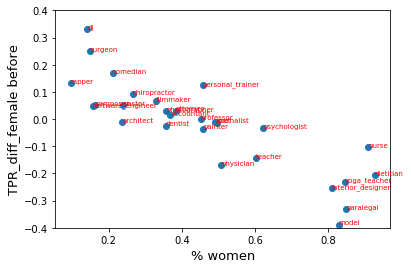

Correlation: -0.47050037099295816; p-value: 0.011512496089877908


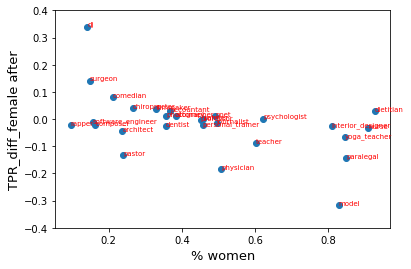

Correlation: -0.6041345489065336; p-value: 0.0006629858782939629


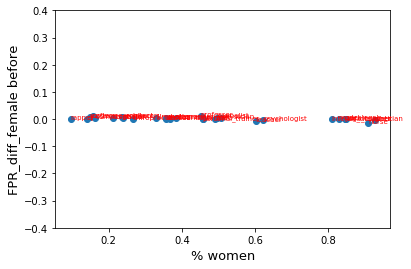

Correlation: -0.3920611414341597; p-value: 0.03907023109414719


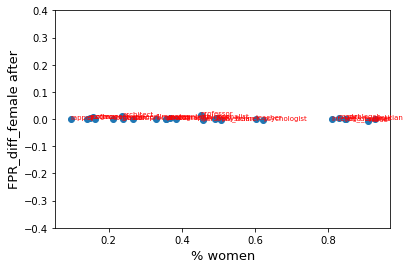

rms-diff before: 0.16237962492055028; rms-diff after: 0.1099359229787996


In [20]:
y_pred_before = clf_original.predict(x_test)
test_gender = [d["g"] for d in test]
tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_before, None, "before", "TPR", prof2fem)


y_pred_after = clf.predict(x_test.dot(P))
#y_pred_after = clf.predict(X_test)
tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_after, None, "after", "TPR", prof2fem)

 
#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
 
fprs_before, fprs_change_before = get_FPR2(y_pred_before, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_before, None, "before", "FPR", prof2fem)


fprs, fprs_change_after = get_FPR2(y_pred_after, y_test, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_after, None, "after", "FPR", prof2fem)

#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
change_vals_before = np.array(list((tprs_change_before.values())))
change_vals_after = np.array(list(tprs_change_after.values()))

print("rms-diff before: {}; rms-diff after: {}".format(rms_diff(change_vals_before), rms_diff(change_vals_after)))

### print(fprs_change_after)

In [114]:
y_test

array([ 2, 21,  2, ..., 26, 25, 22])

In [22]:
def tsne_by_gender(vecs, labels, title, words = None):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  names = list(set(labels)) # ["class {}".format(i) for i in range(num_labels)]
  plt.figure(figsize=(6, 5))
  colors = 'b', 'r', 'orange'
  markers = ["s", "o"]

  for i, c, label, marker in zip(set(labels.tolist()), colors, names, markers):
    print(len(vecs_2d[labels == i, 0]))
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label, alpha = 0.3, marker = marker)
  plt.legend()
  plt.title(title)
  
  if words is not None:
        k = 60
        for i in range(k):
            
            j = np.random.choice(range(len(words)))
            label = labels[i]
            w = words[j]
            x,y = vecs_2d[i]
            plt.annotate(w , (x,y), size = 10, color = "black" if label == 1 else "black")
  plt.savefig(title, dpi = 600)          
  plt.show()
  return vecs_2d

1371
129


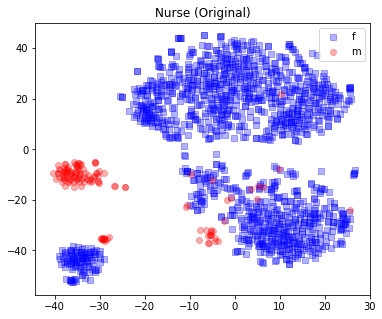

1371
129


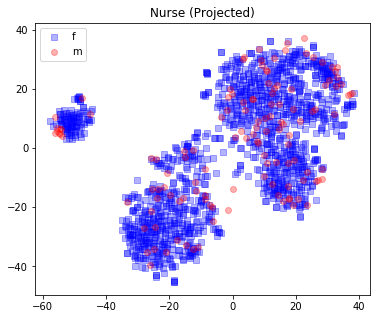

633
867


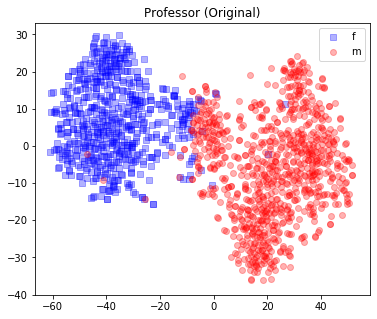

633
867


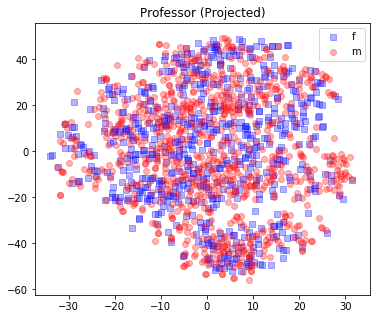

1092
408


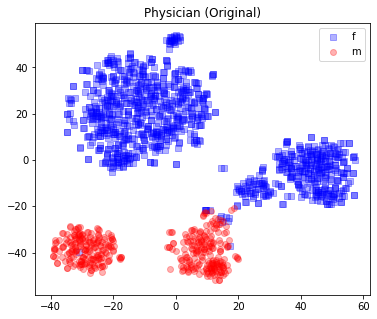

1092
408


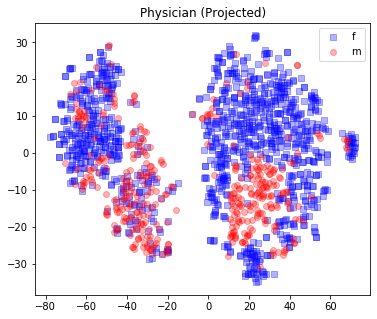

472
941


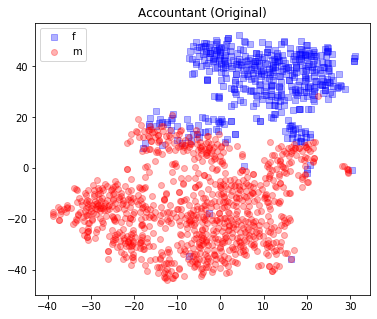

472
941


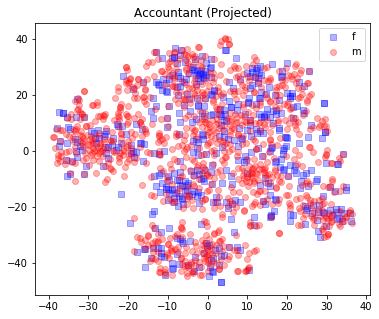

40
331


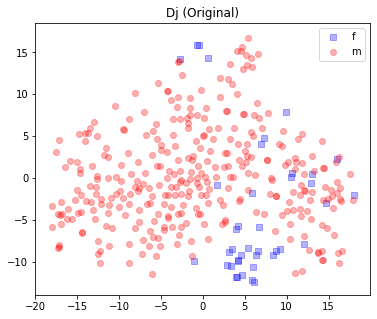

40
331


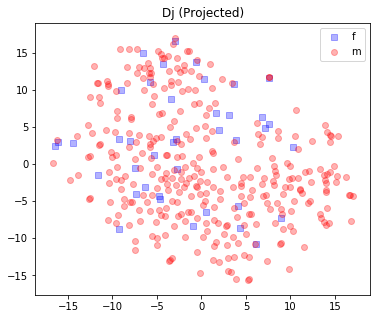

918
76


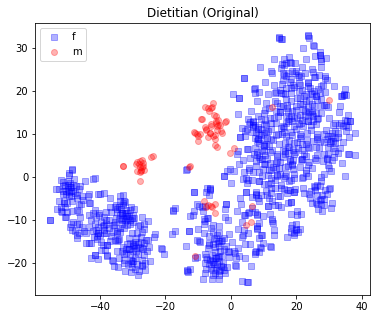

918
76


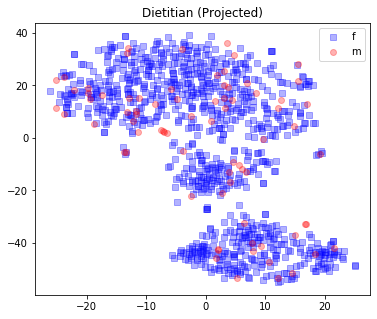

In [25]:
y_test_gender = np.array([d["g"] for d in test])
n = 1500
for prof in ["nurse", "professor", "physician", "accountant", "dj", "dietitian"]:
    
    idx = np.random.rand(x_test.shape[0]) < 0.1
    prof_idx = y_test == p2i[prof]  
    prof_upper = prof[0].upper() + prof[1:]
    tsne_by_gender(x_test[prof_idx][:n], y_test_gender[prof_idx][:n], "{} (Original)".format(prof_upper))
    tsne_by_gender((x_test[prof_idx].dot(P))[:n], y_test_gender[prof_idx][:n], "{} (Projected)".format(prof_upper))

668
832


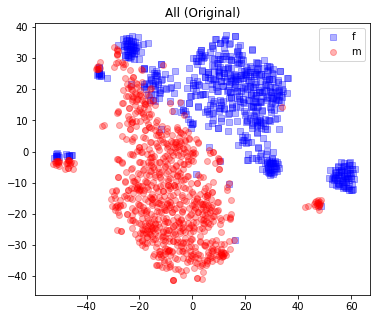

668
832


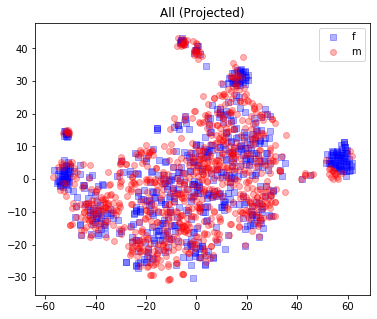

array([[ 16.821629 , -14.759826 ],
       [ -1.9938116,   8.077622 ],
       [ 29.247484 ,  -4.770247 ],
       ...,
       [-19.929117 ,   6.3457165],
       [  4.7806363,   5.868755 ],
       [-19.543705 , -23.543058 ]], dtype=float32)

In [26]:
tsne_by_gender(x_test[:n], y_test_gender[:n], "All (Original)".format(prof_upper))
tsne_by_gender((x_test.dot(P))[:n], y_test_gender[:n], "All (Projected)".format(prof_upper))

In [39]:
print(prof2fem)

{'teacher': 0.603111879476414, 'professor': 0.45118956904580476, 'attorney': 0.38316925813475633, 'surgeon': 0.14857228961048746, 'photographer': 0.35721920736720936, 'painter': 0.4579886246122027, 'psychologist': 0.6223011751844766, 'filmmaker': 0.3295762590954487, 'physician': 0.507688318423441, 'interior_designer': 0.8086124401913876, 'architect': 0.23712053792148718, 'dietitian': 0.9273504273504274, 'pastor': 0.24052132701421802, 'rapper': 0.09665955934612651, 'journalist': 0.49488721804511276, 'dentist': 0.35589474411216243, 'accountant': 0.36818825194621374, 'poet': 0.49080017115960634, 'model': 0.8283124500133298, 'nurse': 0.9085446207369142, 'chiropractor': 0.26558891454965355, 'yoga_teacher': 0.8454600120264583, 'software_engineer': 0.1576889661164205, 'paralegal': 0.8483305036785512, 'composer': 0.16392857142857142, 'personal_trainer': 0.45670391061452514, 'comedian': 0.21150410861021793, 'dj': 0.1420875420875421}
